# Representational Similarity Analysis

Representational similarity analysis (RSA) is a MVPA technique that examines correlations between voxel patterns (i.e between condition A and condition B) to determine their similarity or _dissimilarity_. In the localizer task, we might expect Grasp and Arm to have similar patterns in somatosensory cortex because the movements performed in either condition are very similar. Meanwhile, we might expect Grasp and Arm to be dissimilar to Eye movements, because they are entirely different forms of movement.

Basic RSA is more straightforward to code than basic pattern classification. At minimum, we need one representative pattern of voxels per condition. More sophisticated (and more common) approaches obtain one representative pattern per condition _per run_ in order to cross-validate the patterns for estimating pattern reliability/stability. For the sake of this course and the final project, we'll stick with the minimal approach of one pattern per condition. This is very convenient, because we already have those patterns in our first-level model. Instead of averaging voxel activity within conditions and comparing means, as in an ROI analysis, we'll simply correlate voxel activity between conditions.

First, let's import our dependencies. We have seen many of these before. Some extra scipy modules are imported for correlations and ways to analyze RSA data. There are many ways to compute correlations in Python, and we'll use `pearsonr` to compute an example Pearson correlation. However, we'll mainly use numpy's `corrcoef` function to compute pairwise correlations simply because it is very convenient for generating correlation matrices. We'll be using some nice functions from seaborn to visualize our RSA results. 

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

# useful for correlations and RDM analysis
from scipy import spatial, stats, cluster

from nilearn.input_data import NiftiMasker
from nilearn import image
from nilearn.plotting import plot_roi

import warnings
warnings.filterwarnings('ignore')

Next, load the first-level models:

In [3]:
with open('first_level_models.p', 'rb') as f:
    glms = pickle.load(f)

## 1. Extract ROI voxel patterns

We need to get voxel patterns from the ROI we wish to analyze. Below is code that should be familiar by now (see `7_ROI_Analysis.ipynb`). We will iterate through task conditions, and get the parameter maps (betas). Then we'll extract the voxels from the ROI. Each iteration will produce a subject-by-voxel array. We'll save that array each iteration to `pattern_list`. Finally, we'll convert this list to a numpy array, making it easy to analyze.  

In [4]:
roi_img = 'L_SSc.nii.gz'
conditions = ['Arm', 'Eye', 'Finger', 'Grasp', 'Mouth', 'Speech', 'Toes', 'Touch']

pattern_list = []
for cond in conditions:
    
    # 1. get parameter map of each subject 
    param_maps = []
    for model in glms:
        parameter_map = model.compute_contrast(cond, output_type='effect_size')
        param_maps.append(parameter_map)
        
    # 2. resample ROI mask to functional resolution (2x2x2 -> 3x3x4) 
    roi = image.resample_to_img(roi_img, param_maps[0], 
                                interpolation='nearest')
    
    # 3. set masker and extract voxels
    masker = NiftiMasker(mask_img=roi)
    roi_data = masker.fit_transform(param_maps)
    
    # 4. add extracted data to list
    pattern_list.append(roi_data)
    
    
# convert to 3D array
pattern_array = np.array(pattern_list)

In [5]:
# condition x subject x voxel array
pattern_array.shape

(8, 8, 72)

## 2. Simple correlation analysis

To simply illustrate the correlation approach, we'll take two conditions of a single subject and correlate them. Let's get the Arm (index = 0) and Grasp (index = 3) condition from one subject:

In [6]:
arm = pattern_array[0, 1, :]
grasp = pattern_array[3, 1, :]

In [7]:
r, p = stats.pearsonr(arm, grasp)
r

0.9601010145938196

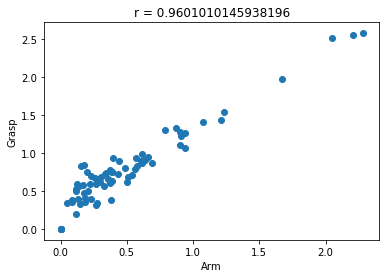

In [10]:
fig, ax = plt.subplots()
ax.scatter(arm, grasp)
ax.set(xlabel='Arm', ylabel='Grasp', title=f'r = {r}');

Now let's correlate arm with eye (index = 1):

In [11]:
eye = pattern_array[1, 1, :]

r, p = stats.pearsonr(arm, eye)
r

0.6443566199537942

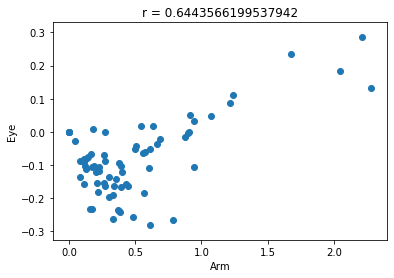

In [12]:
fig, ax = plt.subplots()
ax.scatter(arm, eye)
ax.set(xlabel='Arm', ylabel='Eye', title='r = {}'.format(r));

In this subject, the corretion for Arm and Grasp > the correlation for Arm and Eye. 

## 3. Pairwise correlations and dissimilarity matrices

### 3.1 Correlation matrix
The next step is to perform this correlation for all pairs of conditions for this subject. Numpy has a convenient function called `corrcoef` that lets us compute pairwise correlations in a 2D matrix (where each row = condition, each col = observation/voxel). 

In [13]:
corr_matrix = np.corrcoef(pattern_array[:, 1, :])
corr_matrix = pd.DataFrame(corr_matrix, columns=conditions, index=conditions)
corr_matrix

,Arm,Eye,Finger,Grasp,Mouth,Speech,Toes,Touch
Arm,1.000000,0.644357,0.770898,0.960101,0.524871,0.403323,0.520866,0.614836
Eye,0.644357,1.000000,0.551499,0.525795,0.386275,0.476432,0.734131,0.183203
Finger,0.770898,0.551499,1.000000,0.667061,0.547396,0.381470,0.408693,0.689331
Grasp,0.960101,0.525795,0.667061,1.000000,0.465331,0.366029,0.511477,0.664982
Mouth,0.524871,0.386275,0.547396,0.465331,1.000000,0.464253,0.408948,0.517856
Speech,0.403323,0.476432,0.381470,0.366029,0.464253,1.000000,0.659199,0.297668
Toes,0.520866,0.734131,0.408693,0.511477,0.408948,0.659199,1.000000,0.370334
Touch,0.614836,0.183203,0.689331,0.664982,0.517856,0.297668,0.370334,1.000000


We can plot our results using seaborn's `heatmap` function (see [documentation](https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap)).

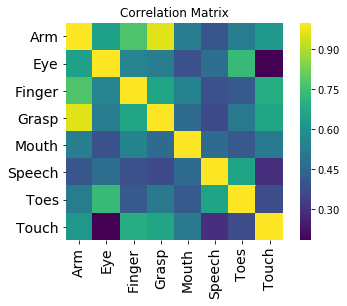

In [15]:
sns.heatmap(corr_matrix, cmap='viridis', square=True)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Correlation Matrix');

We see that Arm and Grasp are highly correlated. Meanwhile, for example, Touch and Eye are the least correlated. 

### 3.2 Representational Dissimilarity Matrix

In RSA, it's common to convert correlation matrices to dissimilarity matrices, otherwise known as _Representational Dissimilarity Matrices_ (RDM). We simply subtract our correlations from 1:

$RDM = 1 - \text{correlation matrix}$




This flips the scale, where larger numbers reflect more dissimilar conditions:

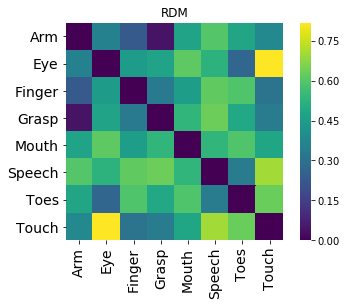

In [16]:
dissim_matrix = 1 - corr_matrix

sns.heatmap(dissim_matrix, cmap='viridis', square=True)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('RDM');

We see that this is the exact same as above, just that everything has been flipped. Eye and Touch are the _most dissimilar_, and Arm and Grasp are the _least dissimilar_. So, the dissimilarity is a measure of the distance between conditions. We can cluster conditions according to their dissimilarity with helpful scipy functions:

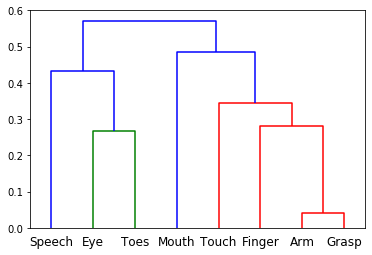

In [18]:
# get upper triangle
distances = spatial.distance.squareform(dissim_matrix, checks=False)

# apply hierarchical clustering 
linkages = cluster.hierarchy.linkage(distances, method='average')

# plot dendogram
dendo = cluster.hierarchy.dendrogram(linkages, labels=conditions)

We can combine our dissimilarity matrix with a dendogram using seaborn's `clustermap` function (see [documentation](https://seaborn.pydata.org/generated/seaborn.clustermap.html#seaborn.clustermap)). We need to pass in our RDM, and the linkage information we obtained above:

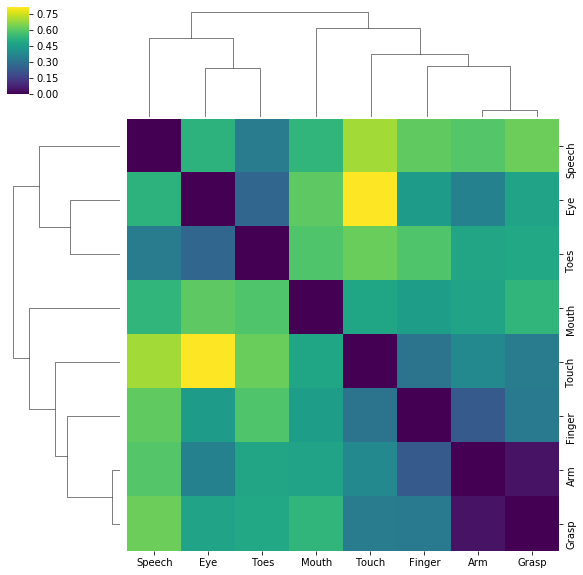

In [19]:
sns.clustermap(dissim_matrix, cmap='viridis', row_linkage=linkages, 
               col_linkage=linkages, square=True);

## 4. Group Analysis

The next step is to repeat the pairwise correlation step for all subjects, so that each subject will have a correlation matrix. We can analyze the average correlation matrix. 

In [21]:
matrices = []
for i in range(8):
    corr_mat = np.corrcoef(pattern_array[:, i, :])
    matrices.append(corr_mat)
matrices = np.array(matrices)

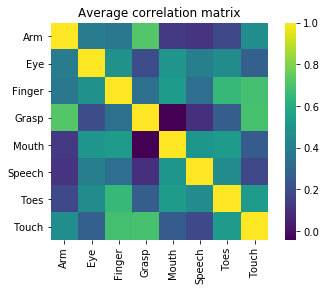

In [22]:
# compute mean across subjects
mean_corr_matrix = np.mean(matrices, axis=0)
# convert to DataFrame for seaborn
mean_corr_matrix = pd.DataFrame(mean_corr_matrix, index=conditions, 
                                columns=conditions)

sns.heatmap(mean_corr_matrix, cmap='viridis', square=True)
plt.title('Average correlation matrix');


Convert this to the average RDM:

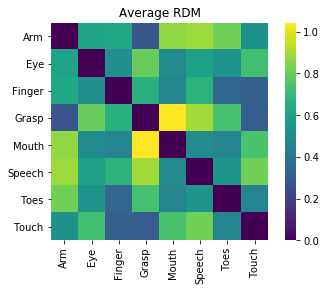

In [24]:
mean_dissim_matrix = 1 - mean_corr_matrix
sns.heatmap(mean_dissim_matrix, cmap='viridis', square=True)
plt.title('Average RDM');

Just as we did with a single subject, we can apply hierarchical clustering to the mean dissimilarity matrix and get a sense of the relational structure of the conditions across the group.

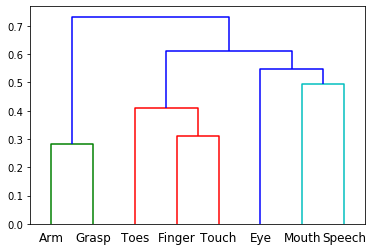

In [27]:
# get upper triangle
distances = spatial.distance.squareform(mean_dissim_matrix, checks=False)

# apply hierarchical clustering 
linkages = cluster.hierarchy.linkage(distances, method='average')

# plot dendogram
dendo = cluster.hierarchy.dendrogram(linkages, labels=conditions)

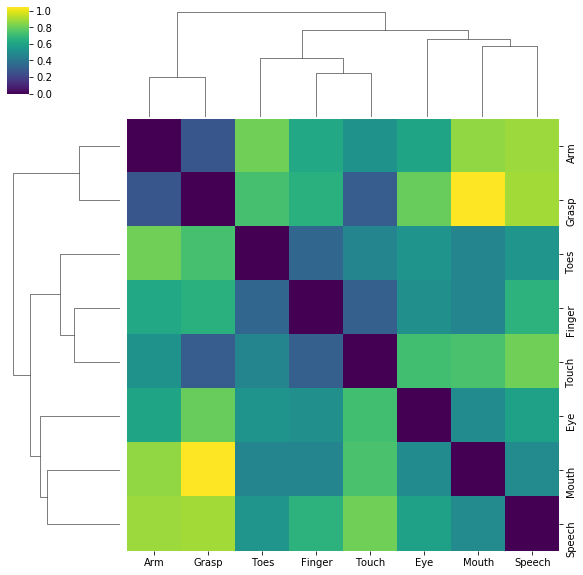

In [29]:
sns.clustermap(mean_dissim_matrix, cmap='viridis', row_linkage=linkages, 
               col_linkage=linkages, square=True);

## 5. Testing RDM Models

Analyzing the mean dissimilarity is useful to understand the structure of the data. We can also test specific _a priori_ models and if the model fits the data well, or better than other models.  


The first step is to specify a model RDM, in which we set elements to 1 if we expect them to be  dissimilar, and 0 if we expect them to be similar. For instance, if we set all off-diagonal elements to 1, then we expect that everything is dissimilar -- the ROI distinctly represents each condition.  

The second step is to take the model RDM and vectorize it (i.e. flatten it to a big vector), and do the same for each subject's RDM. Then, we correlate the vectorized model RDM with each subject's vectorized RDM to get an _r_ value per subject. We can test those _r_ values to determine if the model is good fit. 

**Model 1**  
This model specifies that all conditions are distinctly represented. Note that if we were doing doing cross-validation across functional runs, we would expect the diaganonal to vary.

In [34]:
rdm_1 = np.zeros(shape=(8, 8)) + 1
np.fill_diagonal(rdm_1, 0)
rdm_1 = pd.DataFrame(rdm_1, index=conditions, columns=conditions, dtype=int)
rdm_1

,Arm,Eye,Finger,Grasp,Mouth,Speech,Toes,Touch
Arm,0,1,1,1,1,1,1,1
Eye,1,0,1,1,1,1,1,1
Finger,1,1,0,1,1,1,1,1
Grasp,1,1,1,0,1,1,1,1
Mouth,1,1,1,1,0,1,1,1
Speech,1,1,1,1,1,0,1,1
Toes,1,1,1,1,1,1,0,1
Touch,1,1,1,1,1,1,1,0


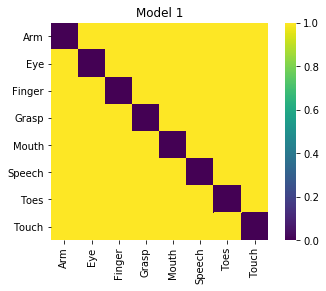

In [35]:
sns.heatmap(rdm_1, cmap='viridis', square=True)
plt.title('Model 1');

**Model 2**  
This model assumes that Arm and Grasp are correlated, and the remaining conditions (Toes, Finger, Touch, Eye, Mouth and Speech) are separately correlated. Note that this model reflects the first branching of the dendogram above. 

In [36]:
rdm_2 = np.zeros(shape=(8, 8)) + 1
np.fill_diagonal(rdm_2, 0)
rdm_2[(3, 0, 1, 2), (0, 3, 2, 1)] = 0
rdm_2[4:, 4:] = 0
rdm_2[4:, 1:3] = 0
rdm_2[1:3, 4:] = 0

rdm_2 = pd.DataFrame(rdm_2, index=conditions, columns=conditions, dtype=int)
rdm_2

,Arm,Eye,Finger,Grasp,Mouth,Speech,Toes,Touch
Arm,0,1,1,0,1,1,1,1
Eye,1,0,0,1,0,0,0,0
Finger,1,0,0,1,0,0,0,0
Grasp,0,1,1,0,1,1,1,1
Mouth,1,0,0,1,0,0,0,0
Speech,1,0,0,1,0,0,0,0
Toes,1,0,0,1,0,0,0,0
Touch,1,0,0,1,0,0,0,0


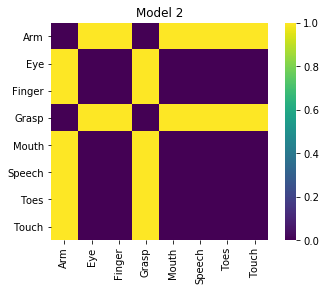

In [37]:
sns.heatmap(rdm_2, cmap='viridis', square=True)
plt.title('Model 2');

**Model 3**  
This model assumes that 1) Arm and Grasp are similar, 2) Toes, Finger and Touch are similar, and 3) Eye, Mouth, and Speech are similar. This reflects the 3 main clusters from the dendograms above.

In [38]:
rdm_3 = np.zeros(shape=(8, 8)) + 1
np.fill_diagonal(rdm_3, 0)
rdm_3[(3, 0), (0, 3)] = 0
rdm_3[6:, 6:] = 0
rdm_3[6:, 2] = 0
rdm_3[2, 6:] = 0
rdm_3[1, 4:6] = 0
rdm_3[4:6, 1] = 0
rdm_3[4:6, 4:6] = 0

rdm_3 = pd.DataFrame(rdm_3, index=conditions, columns=conditions, dtype=int)
rdm_3

,Arm,Eye,Finger,Grasp,Mouth,Speech,Toes,Touch
Arm,0,1,1,0,1,1,1,1
Eye,1,0,1,1,0,0,1,1
Finger,1,1,0,1,1,1,0,0
Grasp,0,1,1,0,1,1,1,1
Mouth,1,0,1,1,0,0,1,1
Speech,1,0,1,1,0,0,1,1
Toes,1,1,0,1,1,1,0,0
Touch,1,1,0,1,1,1,0,0


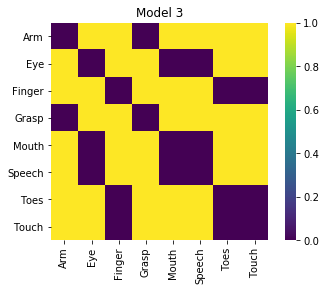

In [39]:
sns.heatmap(rdm_3, cmap='viridis', square=True)
plt.title('Model 3');

**Model Evaluation**  
Now lets write a function to correlate subject matrices with each model matrix.

In [40]:
def test_model(model, subject_matrices):
    r_values = []
    # iterate through subjects
    for mat in subject_matrices:
        # convert to RDM
        rdm = 1 - mat
        # correlate
        r, p = stats.pearsonr(model.values.ravel(), rdm.ravel())
        r_values.append(r)
    return r_values

In [41]:
test_model(rdm_3, matrices)

[0.5363736556663578,
 0.4017913800923733,
 0.4674503629520961,
 0.662744872120816,
 0.49704098715336176,
 0.4443634423879459,
 0.24745111796513058,
 0.5515240057871137]

Now we can plot each result. We'll make a dataframe that has a subject column and a column for each model. We can shape that and feed it into a seaborn plot: 

In [42]:
# make dataframe
df = pd.DataFrame({'subject': range(8),
                   'model 1': test_model(rdm_1, matrices), 
                   'model 2': test_model(rdm_2, matrices), 
                   'model 3': test_model(rdm_3, matrices)})
df = df.melt(id_vars='subject', var_name='model', value_name='r')

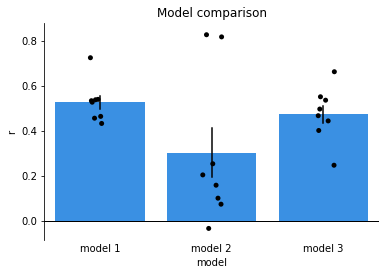

In [43]:
# plot with data point overlay
fig, ax = plt.subplots()
sns.barplot('model', 'r', data=df, ci=68, color='dodgerblue', ax=ax, 
             errcolor='k', errwidth=1.5)
sns.stripplot('model', 'r', data=df, color='k', ax=ax)
ax.set_title('Model comparison')
# add 0 line and tidy up aesthetics
ax.axhline(0, c='k', lw=1)
ax.xaxis.set_tick_params(length=0)
sns.despine(bottom=True)